<a href="https://colab.research.google.com/github/VinaySingh561/GraphML/blob/main/Node_classification_new23.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# !pip install deeprobust
# !conda install pytorch torchvision torchaudio -c pytorch
import torch
# print(torch.__version__)
!pip install torch-scatter torch-sparse -f https://data.pyg.org/whl/torch-{torch.__version__}.html
!pip install torch-geometric
%load_ext autoreload
%autoreload 2
%matplotlib inline
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:90% !important; }</style>"))

from networkx.generators.random_graphs import erdos_renyi_graph
from networkx.generators.random_graphs import barabasi_albert_graph
from networkx.generators.community import stochastic_block_model
from networkx.generators.random_graphs import watts_strogatz_graph
from networkx.generators.community import random_partition_graph

import networkx as nx
import numpy as np
import matplotlib.pyplot as plt

import math
from tqdm import tqdm
import seaborn as sns
from sklearn.decomposition import FactorAnalysis

import random



Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in links: https://data.pyg.org/whl/torch-1.13.1+cu116.html
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 9.4/9.4 MB 52.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.5/4.5 MB 49.6 MB/s eta 0:00:00
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 565.0/565.0 KB 7.3 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 280.2/280.2 KB 25.0 MB/s eta 0:00:00
  Created wheel for torch-geometric: filename=torch_geometric-2.2.0-py3-none-any.whl size=773302 sha256=5dd1bb15a5931cfd31e2feebd4350a3e42dfee1a5575e9b683bc8f28628ccfaa
  Stored in directory: /root/.cache/pip/wheels/59/a3/20/198928106d3169865ae73afcbd3d3d1796cf6b429b55c65378
Successfully built torch-geometric
  Attempting uninstall: psutil
    Found existing installation:

In [2]:
import os
import collections
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.sparse as sp
import torch
from torch import Tensor
import torch_geometric
from torch_geometric.utils import to_networkx
from torch_geometric.datasets import Planetoid
import networkx as nx
from networkx.algorithms import community
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
data_dir = "./data"
os.makedirs(data_dir, exist_ok=True)

In [3]:
import numpy
import torch
%load_ext autoreload
%autoreload 2

%matplotlib inline
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:90% !important; }</style>"))



from networkx.generators.random_graphs import erdos_renyi_graph
from networkx.generators.random_graphs import barabasi_albert_graph
from networkx.generators.community import stochastic_block_model
from networkx.generators.random_graphs import watts_strogatz_graph
from networkx.generators.community import random_partition_graph
import networkx as nx
import numpy as np
import matplotlib.pyplot as plt

import math
from tqdm import tqdm
import seaborn as sns
from sklearn.decomposition import FactorAnalysis
import random

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [4]:
from random import sample

In [5]:
# from deeprobust.graph.data import Dataset

In [6]:
from scipy.sparse import csr_matrix
from scipy.sparse import csgraph
from scipy.sparse.linalg import inv

In [7]:
import os
os.getcwd()

'/content'

In [8]:
dataset = os.path.join(os.getcwd(),'Texas')
dataset

'/content/Texas'

In [9]:
from torch_geometric.datasets import WebKB
from torch_geometric.utils import to_dense_adj,homophily


dataset = WebKB(root='/Texas',name='Texas')
print(dataset[0])

edge_list = dataset[0].edge_index
NO_OF_EDGES = edge_list.shape[1]
labels = dataset[0].y

print("Homophilic ratio : " + str(homophily(edge_list,labels,method='edge')))


adj = to_dense_adj(dataset[0].edge_index)
adj = adj[0]

labels = labels.numpy()

X = dataset[0].x
X = X.to_dense()
N = X.shape[0]
NO_OF_CLASSES = 5

sparsity_original = 2*NO_OF_EDGES/(N*(N-1))
print("Sparsity of original graph : " + str(sparsity_original))


print(X.shape, adj.shape)

nn = int(1*N)
X = X[:nn,:]
adj = adj[:nn,:nn]
labels = labels[:nn]
print(X.shape,adj.shape)

# plot_graph(dataset[0])


Data(x=[183, 1703], edge_index=[2, 325], y=[183], train_mask=[183, 10], val_mask=[183, 10], test_mask=[183, 10])
Homophilic ratio : 0.10769230872392654
Sparsity of original graph : 0.0195160031225605
torch.Size([183, 1703]) torch.Size([183, 183])
torch.Size([183, 1703]) torch.Size([183, 183])


Processing...
Done!


In [10]:
def get_laplacian(adj):
    b=torch.ones(adj.shape[0])
    return torch.diag(adj@b)-adj

theta = get_laplacian(adj)
print(theta.shape)


torch.Size([183, 183])


In [11]:
# dataset_name = 'flickr' 

# data = Dataset(root='', name=dataset_name, setting='gcn',seed=10)

# adj, features, labels = data.adj, data.features, data.labels
# idx_train, idx_val, idx_test = data.idx_train, data.idx_val, data.idx_test

# theta = csgraph.laplacian(adj).tocsr()
features = X.numpy()
NO_OF_NODES = X.shape[0]
# NO_OF_CLASSES =  7


print(NO_OF_CLASSES,NO_OF_NODES)

5 183


In [12]:
def convertScipyToTensor(coo):
  try:
    coo = coo.tocoo()
  except:
    coo = coo
  values = coo.data
  indices = np.vstack((coo.row, coo.col))

  i = torch.LongTensor(indices)
  v = torch.FloatTensor(values)
  shape = coo.shape

  return torch.sparse.FloatTensor(i, v, torch.Size(shape))

In [13]:
from scipy.sparse import random
from scipy.sparse.linalg import norm
from scipy.sparse import csr_matrix

p = X.shape[0]
k = int(p*0.5)
n = X.shape[1]
lambda_param = 100
beta_param = 50
alpha_param = 100
gamma_param = 100
lr = 1e-5
thresh = 1e-10

from scipy.sparse import random
from scipy.stats import rv_continuous
class CustomDistribution(rv_continuous):
    def _rvs(self,  size=None, random_state=None):
        return random_state.standard_normal(size)
temp = CustomDistribution(seed=1)
temp2 = temp()  # get a frozen version of the distribution
X_tilde = random(k, n, density=0.25, random_state=1, data_rvs=temp2.rvs)
C = random(p, k, density=0.25, random_state=1, data_rvs=temp2.rvs)



In [14]:
def experiment(lambda_param,beta_param,alpha_param,gamma_param,C,X_tilde,theta,X):
      p = X.shape[0]
      k = int(p*0.5)
      n = X.shape[1]
      ones = csr_matrix(np.ones((k,k)))
      ones = convertScipyToTensor(ones)
      ones = ones.to_dense()
      J = np.outer(np.ones(k), np.ones(k))/k
      J = csr_matrix(J)
      J = convertScipyToTensor(J)
      J = J.to_dense()
      zeros = csr_matrix(np.zeros((p,k)))
      zeros = convertScipyToTensor(zeros)
      zeros = zeros.to_dense()
      X_tilde = convertScipyToTensor(X_tilde)
      X_tilde = X_tilde.to_dense()
      C = convertScipyToTensor(C)
      C = C.to_dense()
      eye = torch.eye(k)
      try:
        theta = convertScipyToTensor(theta)
      except:
        theta = theta
      try:
        X = convertScipyToTensor(X)
        X = X.to_dense()
      except:
        X = X

      if(torch.cuda.is_available()):
        # print("yes")
        X_tilde = X_tilde.cuda()
        C = C.cuda()
        theta = theta.cuda()
        X = X.cuda()
        J = J.cuda()
        zeros = zeros.cuda()
        ones = ones.cuda()
        eye = eye.cuda()

      def update(X_tilde,C,i):
          global L
          thetaC = theta@C
          CT = torch.transpose(C,0,1)
          X_tildeT = torch.transpose(X_tilde,0,1)
          CX_tilde = C@X_tilde
          t1 = CT@thetaC + J
          term_bracket = torch.linalg.pinv(t1)
          thetacX_tilde = thetaC@(X_tilde)
          
          L = 1/k

          t1 = -2*gamma_param*(thetaC@term_bracket)
          t2 = alpha_param*(CX_tilde-X)@(X_tildeT)
          t3 = 2*thetacX_tilde@(X_tildeT)
          t4 = lambda_param*(C@ones)
          t5 = 2*beta_param*(thetaC@CT@thetaC)
          T2 = (t1+t2+t3+t4+t5)/L
          Cnew = (C-T2).maximum(zeros)
          t1 = CT@thetaC*(2/alpha_param)
          t2 = CT@C
          t1 = torch.linalg.pinv(t1+t2)
          t1 = t1@CT
          t1 = t1@X
          X_tilde_new = t1
          Cnew[Cnew<thresh] = thresh
          for i in range(len(Cnew)):
              Cnew[i] = Cnew[i]/torch.linalg.norm(Cnew[i],1)
          for i in range(len(X_tilde_new)):
            X_tilde_new[i] = X_tilde_new[i]/torch.linalg.norm(X_tilde_new[i],1)
          return X_tilde_new,Cnew


      for i in tqdm(range(20)):
          X_tilde,C = update(X_tilde,C,i)
    
      return X_tilde,C




In [15]:
def experiment2(lambda_param,beta_param,alpha_param,gamma_param,C,X_tilde,theta,X):
      p = X.shape[0]
      k = int(p*0.1)
      n = X.shape[1]
      ones = csr_matrix(np.ones((k,k)))
      ones = convertScipyToTensor(ones)
      ones = ones.to_dense()
      J = np.outer(np.ones(k), np.ones(k))/k
      J = csr_matrix(J)
      J = convertScipyToTensor(J)
      J = J.to_dense()
      zeros = csr_matrix(np.zeros((p,k)))
      zeros = convertScipyToTensor(zeros)
      zeros = zeros.to_dense()
      X_tilde = convertScipyToTensor(X_tilde)
      X_tilde = X_tilde.to_dense()
      C = convertScipyToTensor(C)
      C = C.to_dense()
      eye = torch.eye(k)
      try:
        theta = convertScipyToTensor(theta)
      except:
        theta = theta
      try:
        X = convertScipyToTensor(X)
        X = X.to_dense()
      except:
        X = X

      if(torch.cuda.is_available()):
        # print("yes")
        X_tilde = X_tilde.cuda()
        C = C.cuda()
        theta = theta.cuda()
        X = X.cuda()
        J = J.cuda()
        zeros = zeros.cuda()
        ones = ones.cuda()
        eye = eye.cuda()

      def update(X_tilde,C,i):
          global L
          thetaC = theta@C
          CT = torch.transpose(C,0,1)
          X_tildeT = torch.transpose(X_tilde,0,1)
          CX_tilde = C@X_tilde
          t1 = CT@thetaC + J
          term_bracket = torch.linalg.pinv(t1)
          thetacX_tilde = thetaC@(X_tilde)
          CTX = CT@X
          
          L = 1/k

          t1 = -2*gamma_param*(thetaC@term_bracket)
          t2 = alpha_param*X@((X_tilde - CTX).T)
          # t3 = 2*thetacX_tilde@(X_tildeT)
          t3 = zeros
          t4 = lambda_param*(C@ones)
          t5 = 2*beta_param*(thetaC@CT@thetaC)
          T2 = (t1+t2+t3+t4+t5)/L
          Cnew = (C-T2).maximum(zeros)
          t1 = CT@thetaC*(2/alpha_param)
          t2 = CT@C
          t1 = torch.linalg.pinv(t1+t2)
          t1 = t1@CT
          t1 = t1@X
          X_tilde_new = CTX
          Cnew[Cnew<thresh] = thresh
          for i in range(len(Cnew)):
              Cnew[i] = Cnew[i]/torch.linalg.norm(Cnew[i],1)
          for i in range(len(X_tilde_new)):
            X_tilde_new[i] = X_tilde_new[i]/torch.linalg.norm(X_tilde_new[i],1)
          return X_tilde_new,Cnew


      for i in tqdm(range(25)):
          X_tilde,C = update(X_tilde,C,i)
    
      return X_tilde,C




In [16]:
def experiment3(lambda_param,beta_param,alpha_param,gamma_param,C,X_tilde,theta,X):
      p = X.shape[0]
      k = int(p*0.1)
      n = X.shape[1]
      ones = csr_matrix(np.ones((k,k)))
      ones = convertScipyToTensor(ones)
      ones = ones.to_dense()
      J = np.outer(np.ones(k), np.ones(k))/k
      J = csr_matrix(J)
      J = convertScipyToTensor(J)
      J = J.to_dense()
      zeros = csr_matrix(np.zeros((p,k)))
      zeros = convertScipyToTensor(zeros)
      zeros = zeros.to_dense()
      X_tilde = convertScipyToTensor(X_tilde)
      X_tilde = X_tilde.to_dense()
      C = convertScipyToTensor(C)
      C = C.to_dense()
      eye = torch.eye(k)
      try:
        theta = convertScipyToTensor(theta)
      except:
        theta = theta
      try:
        X = convertScipyToTensor(X)
        X = X.to_dense()
      except:
        X = X

      if(torch.cuda.is_available()):
        # print("yes")
        X_tilde = X_tilde.cuda()
        C = C.cuda()
        theta = theta.cuda()
        X = X.cuda()
        J = J.cuda()
        zeros = zeros.cuda()
        ones = ones.cuda()
        eye = eye.cuda()

      def update(X_tilde,C,i):
          global L,adj
          thetaC = theta@C
          CT = torch.transpose(C,0,1)
          X_tildeT = torch.transpose(X_tilde,0,1)
          CX_tilde = C@X_tilde
          t1 = CT@thetaC + J
          term_bracket = torch.linalg.pinv(t1)
          thetacX_tilde = thetaC@(X_tilde)
          
          L = 1/k

          t1 = -2*gamma_param*(thetaC@term_bracket)
          t2 = alpha_param*(CX_tilde-X)@(X_tildeT)
          t3 = 2*thetacX_tilde@(X_tildeT)
          t4 = lambda_param*(C@ones)
          t5 = 2*beta_param*(adj@C)
          T2 = (t1+t2+t3+t4+t5)/L
          Cnew = (C-T2).maximum(zeros)
          t1 = CT@thetaC*(2/alpha_param)
          t2 = CT@C
          t1 = torch.linalg.pinv(t1+t2)
          t1 = t1@CT
          t1 = t1@X
          X_tilde_new = t1
          Cnew[Cnew<thresh] = thresh
          for i in range(len(Cnew)):
              Cnew[i] = Cnew[i]/torch.linalg.norm(Cnew[i],1)
          for i in range(len(X_tilde_new)):
            X_tilde_new[i] = X_tilde_new[i]/torch.linalg.norm(X_tilde_new[i],1)
          return X_tilde_new,Cnew


      for i in tqdm(range(15)):
          X_tilde,C = update(X_tilde,C,i)
    
      return X_tilde,C




In [17]:
import torch
import torch.nn.functional as F
from torch_geometric.nn import GCNConv


class Net(torch.nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = GCNConv(X.shape[1], 64)
        self.conv2 = GCNConv(64, NO_OF_CLASSES)

    def reset_parameters(self):
        self.conv1.reset_parameters()
        self.conv2.reset_parameters()

    def forward(self, x, edge_index):

        #print("Checking 1: x", x.shape, "Edge index:", edge_index.shape)
        x = self.conv1(x, edge_index)
        #print("Checking 2: convolution done, new x:", x.shape)
        x = F.relu(x)
        #print("Checking 3: x", x.shape, "training:", self.training)
        x = F.dropout(x, training=self.training)
        #print("Checking 4: dropout done new x", x.shape, "Edge index:", edge_index.shape)
        x = self.conv2(x, edge_index)
        #print("Checking 5: x", x.shape)

        return F.log_softmax(x, dim=1)



In [18]:
from random import sample

In [19]:
from torch_geometric.utils import dense_to_sparse,homophily

def get_accuracy(C_0,L,X_t_0):
    global labels, NO_OF_CLASSES,k
    t=[]
    for i in [1,2,3,4,5,6,7,8,9,10]: 
        C_0_new=np.zeros(C_0.shape)
        for i in range(C_0.shape[0]):
            C_0_new[i][np.argmax(C_0[i])]=1
        # print(C_0_new)
        # C_0_new=C_0
        from scipy import sparse
        #Lc=C_0.T@L@C_0
        Lc=C_0_new.T@L@C_0_new
        # print("L:", Lc.shape)
        # Lc=L_new
        #print(Lc)
        Wc=(-1*Lc)*(1-np.eye(Lc.shape[0]))
        # print("W:", Wc.shape)
        Wc[Wc<0.1]=0
        Wc=sparse.csr_matrix(Wc)
        Wc = Wc.tocoo()
        row = torch.from_numpy(Wc.row).to(torch.long)
        col = torch.from_numpy(Wc.col).to(torch.long)
        edge_index_coarsen2 = torch.stack([row, col], dim=0)
        #print("edgecoarsen:", edge_index_coarsen2.shape)
        edge_weight = torch.from_numpy(Wc.data)
        #print("edgeweight:", edge_weight.shape)
        def one_hot(x, class_count):
            return torch.eye(class_count)[x, :]

        device = torch.device('cpu')
        labels=labels
        Y = labels
        #print("Y:", Y.shape)
        Y = one_hot(Y,NO_OF_CLASSES)
        # NO_OF_CLASSES=Y.shape[1]
        P=np.linalg.pinv(C_0_new)
        labels_coarse = torch.argmax(torch.sparse.mm(torch.Tensor(P).double() , Y.double()).double() , 1)
        #print("Lables:", labels_coarse.shape)

        #torch.Tensor(C2)@X
        # Wc[Wc<0.01]=0
        Wc=Wc.toarray()
        adjtemp = torch.tensor(Wc)
        edge_list_temp = dense_to_sparse(adjtemp)[0]
        # print(edge_list_temp)
        # print(labels_coarse)
        print("Homophilic ratio : " + str(homophily(edge_list_temp,labels_coarse,method='edge')))
        number_of_edges = edge_list_temp.shape[1]
        n = labels_coarse.shape[0]
        sparsity = 2*number_of_edges/(n*(n-1))
        print("Sparsity : " + str(sparsity))
    
        #
        C2=np.linalg.pinv(C_0_new)
        model=Net().to(device)
        device = torch.device('cpu')
        lr=0.01
        decay=0.0001
        try:
          X=np.array(features.todense())
        except:
          X = np.array(features)
        #print("X:",X.shape)
        optimizer = torch.optim.Adam(model.parameters(), lr=lr, weight_decay=decay)
        # criterion=torch.nn.CrossEntropyLoss()
        x=sample(range(0, int(k)), k)
      
        from datetime import datetime
        Xt=P@X
        # Xt=X_t_0
        def train():
            model.train()
            optimizer.zero_grad()
            out = model(torch.Tensor(Xt).to(device),edge_index_coarsen2)
            loss = F.nll_loss(out[x], labels_coarse[x])
            loss.backward()
            optimizer.step()
            return loss
        now1 = datetime.now()
        losses=[]
        for epoch in range(100):
            loss=train()
            losses.append(loss)
            if(epoch%100==0):
                print(f'Epoch: {epoch:03d},loss: {loss:.4f}')
        now2 = datetime.now()        
        pred=model(torch.Tensor(Xt).to(device),edge_index_coarsen2).argmax(dim=1)        
        def train_accuracy():
            model.eval()
            correct = (pred[x] == labels_coarse[x]).sum()
            acc = int(correct) /len(x)
            return acc
    
        t+=[(now2-now1).total_seconds()]

        zz=sample(range(0, int(NO_OF_NODES)), NO_OF_NODES)
        Wc=sparse.csr_matrix(adj)
        Wc = Wc.tocoo()
        row = torch.from_numpy(Wc.row).to(torch.long)
        col = torch.from_numpy(Wc.col).to(torch.long)
        edge_index_coarsen = torch.stack([row, col], dim=0)
        edge_weight = torch.from_numpy(Wc.data)
        pred=model(torch.Tensor(X),edge_index_coarsen).argmax(dim=1)
        pred=np.array(pred)
        correct =(pred[zz]==labels[zz]).sum()
        acc = int(correct) /NO_OF_NODES
        return acc



In [20]:
from torch_geometric.utils import dense_to_sparse,homophily

def getSparsityAndHomophily(C,theta):
    theta = C.T@theta@C
    adjtemp = -theta
    for i in range(adjtemp.shape[0]):
      adjtemp[i,i]=0
    adjtemp[adjtemp<0.01]=0
    temp = dense_to_sparse(adjtemp)
    edge_list_temp = temp[0]
    # ytemp = temp[1]
    # P = torch.linalg.pinv(C)
    # labels = 
    # # print(edge_list)
    number_of_edges = edge_list_temp.shape[1]
    # n = adjtemp.shape[0]

    # print("Homophilic ratio : " + str(homophily(edge_list_temp,ytemp,method='node')))
    sparsity = 2*number_of_edges/(n*(n-1))
    print("Sparsity : " + str(sparsity))
    

In [21]:
import seaborn as sns
import matplotlib.pylab as plt
from torch_geometric.utils import dense_to_sparse,homophily
        # sns.heatmap(C_0.T@C_0)
        

#0.0001,0.0001,10,0.0001
for lambda_param in [0.0001, 0.001, 0.01, 0.1, 1, 10, 100]:
  for beta_param in [0.0001, 0.001, 0.01, 0.1, 1, 10,100]:
    for alpha_param in [0.0001, 0.001, 0.01, 0.1, 1,10,100]:
      for gamma_param in [0.0001, 0.001, 0.01, 0.1, 1,10,100]:

        av = []

        for _ in range(3):

          X_tilde = random(k, n, density=0.15, random_state=1, data_rvs=temp2.rvs)
          C = random(p, k, density=0.15, random_state=1, data_rvs=temp2.rvs)

          # try:

          X_t_0,C_0 = experiment(lambda_param,beta_param,alpha_param,gamma_param,C,X_tilde,theta,X)
          L = theta
          
          # Ltemp = (C_0.T)@theta@C_0
          # adjtemp = -Ltemp
          # for i in range(adjtemp.shape[0]):
          #   adjtemp[i,i]=0
          # temp = dense_to_sparse(adjtemp)
          # edge_list_temp = temp[0]
          # ytemp = temp[1]
          # # print(edge_list)
          # number_of_edges = edge_list_temp.shape[0]
          # n = adjtemp.shape[0]

          # print("Homophilic ratio : " + str(homophily(edge_list_temp,ytemp)))
          # sparsity = 2*number_of_edges/(n*(n-1))
         



          getSparsityAndHomophily(C_0,theta)

          C_0 = C_0.cpu().detach().numpy()
          X_t_0 = X_t_0.cpu().detach().numpy()
          C_t_0 = C_0.T
          
          try:
            L = L.cpu().detach().numpy()
          except:
            L = L
          
          acc = get_accuracy(C_0,L,X_t_0)
          av.append(acc)
          # if(acc < 0.80):
          #   break
          print("Accuracy = " + str(acc) + " " + str(lambda_param)+" " + str(beta_param)+" "+str(alpha_param)+" "+str(gamma_param))

          # except:

              # print("SVD DID NOT CONVERGE")

        print("Average accuracy = " + str(np.mean(av)*100)  + " +/- " + str(np.std(av)*100)) 
     

    # X_t_0 = X_tilde
    # X = X.cpu().detach().numpy()

100%|██████████| 20/20 [00:04<00:00,  4.15it/s]


RuntimeError: ignored

### Data Exploration

In [22]:
type(dataset)

torch_geometric.datasets.webkb.WebKB

Number of graphs: 1
Number of features: 1703
Number of classes: 5


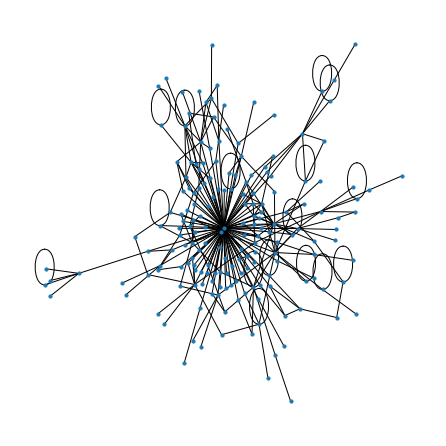

In [23]:
# Print some dataset statistics
print('Number of graphs:', len(dataset))
print('Number of features:', dataset.num_features)
print('Number of classes:', dataset.num_classes)

# Visualize one of the graphs using NetworkX
G = nx.Graph()
G.add_nodes_from(range(dataset[0].num_nodes))
G.add_edges_from(dataset[0].edge_index.t().tolist())

plt.figure(figsize=(6, 6))
nx.draw(G, node_size=10)
plt.show()

In [24]:
# Access the feature matrix of the first graph in the dataset
first_graph_features = dataset[0].x

print(first_graph_features.shape)


torch.Size([183, 1703])


(array([[1657.,    0.,    0., ...,    0.,    0.,   46.],
        [1472.,    0.,    0., ...,    0.,    0.,  231.],
        [1677.,    0.,    0., ...,    0.,    0.,   26.],
        ...,
        [1613.,    0.,    0., ...,    0.,    0.,   90.],
        [1633.,    0.,    0., ...,    0.,    0.,   70.],
        [1658.,    0.,    0., ...,    0.,    0.,   45.]]),
 array([0. , 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1. ],
       dtype=float32),
 <a list of 183 BarContainer objects>)

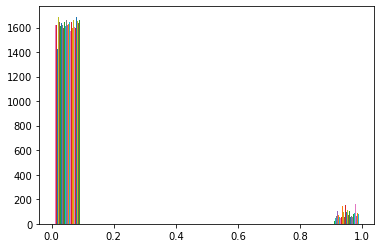

In [25]:
plt.hist(first_graph_features[:,:])

In [26]:
def count(x):
  count  = 0
  for i in range(len(x)):
    if x[i]==1:
      count += 1
  return count   

### 183 Nodes

In [27]:
import matplotlib.pyplot as plt
dict = {}
for i in range(len(first_graph_features[:,0])):
  dict[str(i)] = count(first_graph_features[i,:])

In [28]:
import pandas as pd
feature_data = pd.DataFrame(dict, index = ["Vinay"])

<AxesSubplot:>

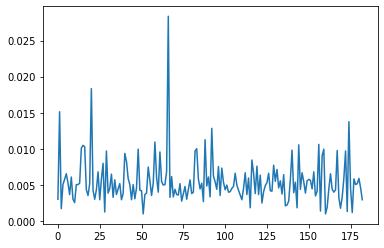

In [29]:
(feature_data.iloc[0]/feature_data.iloc[0].sum()).plot()

In [30]:
probabilty_data_feature = feature_data.iloc[0]/feature_data.iloc[0].sum()

In [31]:
probabilty_data_feature

0      0.003013
1      0.015132
2      0.001703
3      0.005044
4      0.005764
         ...   
178    0.005044
179    0.005175
180    0.005895
181    0.004585
182    0.002948
Name: Vinay, Length: 183, dtype: float64

In [32]:
feature_data.head()

,0,1,2,3,4,5,6,7,8,9,...,173,174,175,176,177,178,179,180,181,182
Vinay,46,231,26,77,88,100,81,56,93,46,...,20,210,68,18,89,77,79,90,70,45


### 1703 features at every node

In [33]:
dict_1 = {}
for i in range(len(first_graph_features[0,:])):
  dict_1[str(i)] = count(first_graph_features[:,i])

import pandas as pd
feature_dataset = pd.DataFrame(dict_1, index = ["Vinay_features"])  
feature_dataset.head()

,0,1,2,3,4,5,6,7,8,9,...,1693,1694,1695,1696,1697,1698,1699,1700,1701,1702
Vinay_features,1,1,4,2,9,3,5,4,5,0,...,1,3,10,1,5,3,2,4,6,0


In [34]:
probabilty_dataset_feature = feature_dataset.iloc[0]/feature_dataset.iloc[0].sum()

In [35]:
probabilty_dataset_feature

0       0.000066
1       0.000066
2       0.000262
3       0.000131
4       0.000590
          ...   
1698    0.000197
1699    0.000131
1700    0.000262
1701    0.000393
1702    0.000000
Name: Vinay_features, Length: 1703, dtype: float64

In [39]:
probabilty_dataset_feature.values.shape

(1703,)

In [46]:
P = np.dot(probabilty_data_feature.values.reshape(-1,1),probabilty_dataset_feature.values.reshape(-1,1).T)

In [47]:
P.shape

(183, 1703)

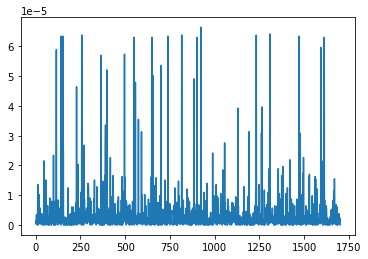

In [54]:
plt.plot(P[150])

In [55]:
#Total Probability
P[:].sum()

0.9999999999999998